## Tensorflow - Nonlinear Dynamical Systems    

#### General Models
* Lorenz Attractor  
* Reaction-Diffusion <i>(Future)</i>  
* Heat Equation on Regions with a Fractal Boundary <i>(Future)</i>  


In [1]:
# Shebang
import tensorflow as tf
import numpy as np
from numpy.fft import fft, fftfreq, rfft, fftshift
import matplotlib.pyplot as plt
import logging

import Helper as hp

#### Lorenz Attractor  

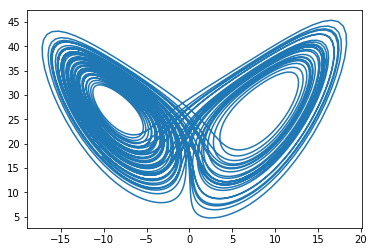

In [2]:
# Model Parameters

rho = 28.0
sigma = 10.0
beta = 8.0/3.0
inits = [0, 2, 20]

# Lorenz equations - Proof of concept for Tensorflow ODE solving

def lorenz_equation(state, t):
    x, y, z = tf.unstack(state)
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return tf.stack([dx, dy, dz])

# Session Definition

sess = tf.Session()
state, info = sess.run(hp.generate_odesolution(lorenz_equation, inits, n=5000))
x, y, z = state.T
plt.plot(x, z)

#### Logistic Map

Text(0, 0.5, '$x_n$')

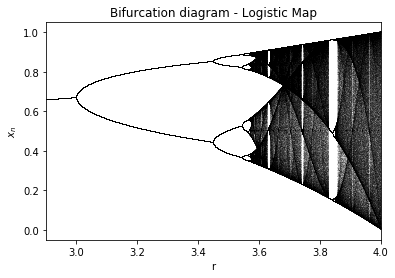

In [3]:
# Model Parameters

n = 20000     # number of r value steps b/w initial and final value
r = np.linspace(2.9, 4.0, n)     # range of r values
iterations = 1500      # total number of iterations
lastits = 100      # number of iterations used to generate map after transients have decayed out
x = 1e-7 * np.ones(n)      # initial conditions of the logistic equation


def logistic(r, x):
    return r*x*(1-x)

plt.figure()
for i in range(iterations):
    x = logistic(r, x)
    if i >= (iterations - lastits):
        plt.plot(r, x, ',k', alpha=.06)
plt.xlim(2.9, 4)
plt.title('Bifurcation diagram - Logistic Map')
plt.xlabel('r')
plt.ylabel('$x_n$')

#### HIV-dynamics model

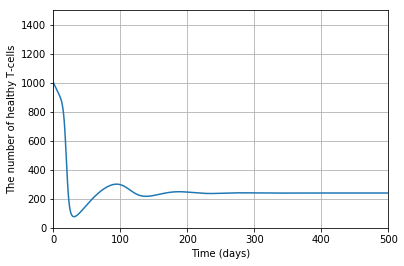

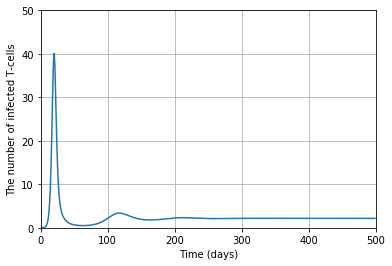

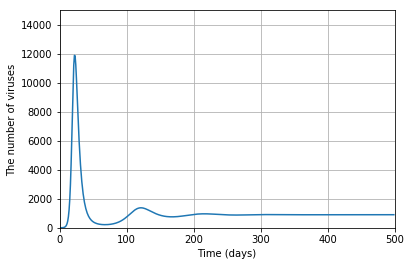

In [9]:
# Model Parameters

s = 10
d = 0.02
u1 = 0.24
u2 = 2.4
beta = 2.4e-5
k = 100
inits = [1000, 0, 1]

# HIV-dynamics model - branching out into other third order biological systems

def hiv_dynamics(state, t):
    x1, x2, x3 = tf.unstack(state)
    dx1 = -d*x1 - beta*x1*x3 + s
    dx2 = -u2*x2 + beta*x1*x3
    dx3 = k*x2 - u1*x3
    return tf.stack([dx1, dx2, dx3])

# Session Definition

sess = tf.Session()
state, info = sess.run(hp.generate_odesolution(hiv_dynamics, inits, t0=0, tfinal=500, n=500))
x, y, z = state.T

# Plot the things

hp.plotface(x, xlim=[0, 500], ylim=[0, 1500], 
            xlabel='Time (days)', ylabel='The number of healthy T-cells', 
            grid=1)
hp.plotface(y, xlim=[0, 500], ylim=[0, 50], 
            xlabel='Time (days)', ylabel='The number of infected T-cells', 
            grid=1)
hp.plotface(z, xlim=[0, 500], ylim=[0, 15000], 
            xlabel='Time (days)', ylabel='The number of viruses', 
            grid=1)

#### Reaction-Diffusion  

In [3]:
# Borked until PDEs on fractal boundaries work